# FastText + NN

### __Author__: Patrick Steiner

__Created__: 31.03.2020

__Version__: 3

__Description__: Creates sentence embedding based on tf-idf and word-embedding and feeds this in a NN




|Change ID | Date       |  Author             |Change Description                   |
|----------|------------|---------------------|--------------------------------------|
|#SK01     | 03.04.2020 | Severin Kappeler    |Re-define corpus with split by sentence rather than by document | 
|#SK02     | 03.04.2020 | Severin Kappeler    |Embedding matrix weighted by TF-IDF score for each word-embedding vector. Using here the "global" TF-IDF. For a given word the "global" TF-IDF score is the average of all the TF-IDF scores for that word over all documents.  | 
|#SK03     | 03.04.2020 | Severin Kappeler    |Apply tokenize.texts_to_sequence to sentence list rather than document list| 
|#SK04     | 03.04.2020 | Severin Kappeler    |Converting label (target) to be on sentence level rather than document level.      | 
|#SK05     | 03.04.2020 | Severin Kappeler    |Adding split to sentence part for features |
|#SK06     | 03.07.2020 | Katalin Horvath     |Replace Word2vec with FastText, adapt TF-IDF vocabulary to FastText|
|#SK07     | 03.07.2020 | Katalin Horvath     |Replace training data with similarity scores data|

In [2]:
# see also 06-Natural-Language_processing notebooks. This one focuses only on doc2vec.
import pandas as pd
pd.options.mode.chained_assignment = None 
import numpy as np
import re
import nltk
import os
import smart_open
import collections
import scipy.stats as stats
import tensorflow as tf
import gensim
import tqdm
import warnings
import io
from pprint import pprint as print

# !pip install fasttext
import fasttext as FT

from gensim.models.word2vec import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models.fasttext import FastText as FT_gensim
#from gensim.models.wrappers import FastText
from gensim.test.utils import datapath
from gensim.test.utils import common_texts
from gensim.test.utils import get_tmpfile

from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Dense, Flatten, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

from nltk import word_tokenize
from nltk.stem import PorterStemmer

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix,roc_auc_score, roc_curve, mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier, LinearRegression, LogisticRegression
from sklearn.naive_bayes import MultinomialNB
#from sklearn.model_selection import GridSearchCV, RandomSearch
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm, tree
import xgboost

In [3]:
# this just for now, because Windows. A helper with somme missing methods from fasttext. Needed for loadin the .bin pretrained model.
# Othervise, just use fasstext.util (imported as FT.util) (also not the gensim one)
import FT_util

# Preprocessing

## Import

In [4]:
#os.chdir('/Users/patrickrs/Documents/GitLab/patrick-steiner/Exercises')
news1_raw = pd.read_csv('../data/raw/2012.SMTnews.test.csv', sep='\t', header=None, names=['SimilarityScore', 'sentence1', 'sentence2'])
news2_raw = pd.read_csv('../data/raw/2014.deft-news.test.csv', sep='\t', header=None, names=['SimilarityScore', 'sentence1', 'sentence2'])

news_raw = news1_raw.copy()
news_raw = news_raw.append(news2_raw)
news_raw.drop_duplicates(inplace=True)
news_raw.reset_index(inplace=True, drop = True)

In [5]:
# mark pairs rated under 2.0 SimilarityScore as unsimilar (0) and similar (1) above that:
news_raw['binary'] = news_raw['SimilarityScore'].apply(lambda x: 0 if x<2 else 1)

In [6]:
news_raw

,SimilarityScore,sentence1,sentence2,binary
0,4.000,Last year he was wanted for murder.,Last year it was sought to murder.,1
1,5.000,Pro-market economists don't object to corporat...,Economists' not against the companies openly u...,1
2,5.000,"And, perhaps most importantly, Ahmadinejad is ...","And, perhaps the most important, Ahmadinejad d...",1
3,4.667,A Europe for All,All Europe,1
4,4.500,"Gays and other ""modern"" practices are rejected...","The gay and other practical ""Modern"" are rejec...",1
...,...,...,...,...
649,1.800,indian and pakistani governments nearly engage...,indian and pakistani governments each conducte...,0
650,3.800,iguaran stated that the detainees will be accu...,iguaran stated that the detainees were also in...,1
651,2.400,3 suspected extremists were released on bail.,1 suspected extremist was provisionally releas...,1
652,0.800,6 czech hospital employees are charged with hu...,the accused will be charged with international...,0


In [35]:
X_train_1, X_test_1, X_train_2, X_test_2 ,y_train_bin, y_test_bin, y_train_sim, y_test_sim = train_test_split(
    news_raw['sentence1'], 
    news_raw['sentence2'],
    news_raw['binary'],
    news_raw['SimilarityScore'],
    test_size=0.2, random_state=42)

In [36]:
print(len(X_train_1))
print(len(X_test_1))

print(len(X_train_2))
print(len(X_test_2))

print(len(y_train_bin))
print(len(y_test_bin))

print(len(y_train_sim))
print(len(y_test_sim))

523
131
523
131
523
131
523
131


## Cleaning

In [37]:
STOP_WORDS = nltk.corpus.stopwords.words('english')

In [38]:
# tokenizer function
def tokenize_text(text):
    
    text_tokenized = nltk.word_tokenize(text)
    text_tokenized = [x.lower() for x in text_tokenized]
    wordlist = []
    for word in text_tokenized: 
        
        if ((word not in STOP_WORDS) and (len(word)>2)):            
            wordlist.append(word)
        # if not (word.isalnum()):            
        # text_tokenized.remove(word)
            
    return(wordlist)

In [39]:
X_train_all = X_train_1.append(X_train_2)
X_train_all.index = range(len(X_train_all))

X_test_all = X_test_1.append(X_test_2)
X_test_all.index = range(len(X_test_all))

In [40]:
X_train_1_clean = [tokenize_text(sentence) for sentence in X_train_1]
X_train_2_clean = [tokenize_text(sentence) for sentence in X_train_2]

X_test_1_clean = [tokenize_text(sentence) for sentence in X_test_1]
X_test_2_clean = [tokenize_text(sentence) for sentence in X_test_2]

X_train_all_clean = X_train_1_clean + X_train_2_clean
X_test_all_clean = X_test_1_clean + X_test_2_clean

# Embedding

## FastText (Pretrained on Wikipedia)

https://radimrehurek.com/gensim/models/fasttext.html

https://fasttext.cc/docs/en/crawl-vectors.html

In [ ]:
# these would be the pretrained fasttext word embeddings, but no model, not trainable, no word segment embeddings:

# model_pt = gensim.models.KeyedVectors.load_word2vec_format('../wiki-news-300d-1M.vec') 

In [41]:
# get the pretrained fasstext .bin model, only do this once, it is big
FT_util.download_model('en', if_exists='ignore')


# load the model
model_4 = FT.load_model('cc.en.300.bin')
#ft.save_model('cc.en.300.bin') # just in case

## TF-IDF

In [42]:
#SK02
#this function creates the (for now only global) TF-IDF weights for each word.
def calc_tf_idf(cleaned_doc_str = None, vocab = None):
    #Calculate TF-IDF score for all words in the corpus
    tfidf = TfidfVectorizer(
          sublinear_tf=True
        , min_df=1
        , norm='l2'
        , encoding='latin-1'
        , ngram_range=(1,1)  #considering only 1-grams for now
        , token_pattern= '(?u)\\b\\w+\\b' #changed from default in order to also include single letters in case they appear in the corpus.
        , tokenizer=nltk.word_tokenize #we pass the corpus as words already.
        , stop_words=None #we already removed stopwords
        , vocabulary = vocab
    ) 
    tfidf_matrix = tfidf.fit_transform(cleaned_doc_str).toarray()    
    tfidf_matrix = pd.DataFrame(tfidf_matrix, columns = tfidf.get_feature_names())
                                    
    #if(not(len(tfidf.get_feature_names()) == len(model_3.wv.vocab.keys()))):
    #   warnings.warn('The count of vocabulary from the word embedding does not coincide with the TF-IDF Vectorizer features.')
    
    return tfidf_matrix
    #None
    #tfidf_matrix contains TF-IDF scores for each document (in the rows) and word (in the columns)
    #tfidf.get_feature_names() gives you the words in the order 

In [43]:
X_train_all_tfidf = calc_tf_idf(X_train_all)
X_test_all_tfidf = calc_tf_idf(X_test_all)

print(X_train_all_tfidf.shape)
print(X_test_all_tfidf.shape)

(1046, 2202)
(262, 1038)


# Similarity metrics

## Combine FastText & TF-IDF

Should there be a way to weight tfidf weights...?

(means: possibility to play with how mucht influence it has on the resulting embeddings)

In [44]:
#loop through tfidf feature_names (the model vocab can be much larger since pretrained. But we are only interested in our own words from the corpus.)
def embedding_sentence(sentence, model, tfidf):
    '''
    This function is to average all words vectors in a given sentence, wegihting them by their tfidf-score.

    Parameters
    ----------
    sentence : a list of token strings
    
    model : a word embedding model 
            which can give an embedding vector 
            for each token in sentence
            
    tfidf : the tfidf weights vector of sentence
    '''
    sentence_embedding = pd.DataFrame([model.get_word_vector(i)*tfidf[i] for i in sentence]).mean()
    return(sentence_embedding)


In [45]:
X_train_all_embeddings = pd.DataFrame([embedding_sentence(X_train_all_clean[i], model_4, X_train_all_tfidf.iloc[i,:]) for i in range(len(X_train_all_clean))])
X_test_all_embeddings = pd.DataFrame([embedding_sentence(X_test_all_clean[i], model_4, X_test_all_tfidf.iloc[i,:]) for i in range(len(X_test_all_clean))])

In [46]:
X_train_1_embeddings = X_train_all_embeddings[:len(X_train_1)]
X_train_2_embeddings = X_train_all_embeddings[len(X_train_1):]
X_train_2_embeddings.index = X_train_1_embeddings.index

X_test_1_embeddings = X_test_all_embeddings[:len(X_test_1)]
X_test_2_embeddings = X_test_all_embeddings[len(X_test_1):]
X_test_2_embeddings.index = X_test_1_embeddings.index

## Cosine similarity

In [47]:
X_train_sim = np.array([(
    cosine_similarity(
        np.array(X_train_1_embeddings.iloc[i,:]).reshape(1,-1),
        np.array(X_train_2_embeddings.iloc[i,:]).reshape(1,-1)
    ))[0,0] for i in range(len(X_train_1))])

X_test_sim = np.array([(
    cosine_similarity(
        np.array(X_test_1_embeddings.iloc[i,:]).reshape(1,-1),
        np.array(X_test_2_embeddings.iloc[i,:]).reshape(1,-1)
    ))[0,0] for i in range(len(X_test_1))])

# BINARY / LOGIT

In [53]:
X_train = X_train_sim
X_test = X_test_sim
y_train = y_train_bin
y_test = y_test_bin

logit = LogisticRegression(class_weight = 'balanced')
clf = logit.fit(X = X_train.reshape(-1, 1), y = y_train)
y_pred = clf.predict(X_test.reshape(-1, 1))
mse_baseline = mean_squared_error(y_true = y_test, y_pred = y_pred)
mse_baseline

0.16030534351145037

In [54]:
# generate a no skill prediction (majority class)
ns_probs = [1 for _ in range(len(y_test))]

In [55]:
# predict probabilities
lr_probs = logit.predict_proba(X_test.reshape(-1, 1))

In [56]:
 # keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

'No Skill: ROC AUC=0.500'
'Logistic: ROC AUC=0.934'


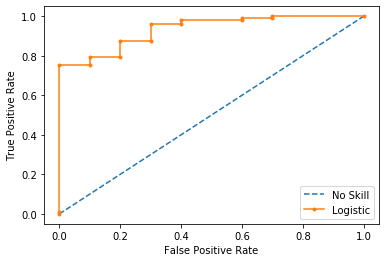

In [57]:
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

# Similarity plots

In [65]:
sim_human = y_train_sim.append(y_test_sim)
sim_cosine = X_test_sim.append(X_test_sim)

AttributeError: 'numpy.ndarray' object has no attribute 'append'

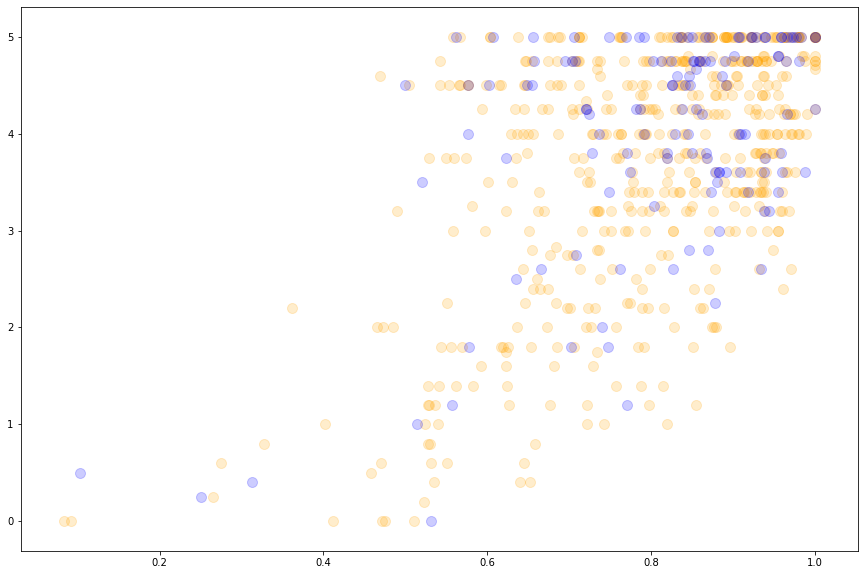

In [64]:
# this plot shows the raw cosine similarity scores of sentence pairs
# according to the human similarity scores
# ideally, this should be a positive correlation

fig = plt.figure(figsize=(15,10))
#plt.xlim(0.99,1) 
plt.scatter(X_train_sim, y_train_sim, alpha = 0.2, s = 100, c = 'orange')
plt.scatter(X_test_sim, y_test_sim, alpha = 0.2, s = 100, c = 'blue')